# COVID-19: Corona infections in Germany (by state)
based on numbers of the RKI (Robert Koch-Institut)

In [40]:
!pip install pyquery

In [41]:
from IPython.core.display import display, HTML

import re
import pandas as pd

from datetime import datetime
from datetime import date, timedelta
from dateutil import parser

from pyquery import PyQuery as pq
from lxml import etree
import urllib

## Gather data
No historical data is provided, so we'll get it with the help of the Wayback Machine 

In [42]:
# Gather URLs as data source for every relevant day

sdate = date(2020, 3, 1)  
edate = datetime.today().date()  

urls = []

for i in range((edate - sdate).days + 1):
    day = sdate + timedelta(days=i)
    day_str = day.strftime("%Y%m%d")
    urls.append(f"https://web.archive.org/web/{day_str}/https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html")
    
# Let's be extra sure we also got the latest numbers:
urls.append('https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html')

urls

['https://web.archive.org/web/20200301/https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html',
 'https://web.archive.org/web/20200302/https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html',
 'https://web.archive.org/web/20200303/https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html',
 'https://web.archive.org/web/20200304/https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html',
 'https://web.archive.org/web/20200305/https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html',
 'https://web.archive.org/web/20200306/https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html',
 'https://web.archive.org/web/20200307/https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html',
 'https://web.archive.org/web/20200308/https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html',
 'https://web.archive.org/web/20200309/https://www.rki.d

In [43]:
tables = {}

for url in urls:
    d = pq(url=url)
    
    date_str = re.search(r"Stand: ?([0-9]{1,2}\.[0-9]{1,2}\.[0-9]{2,4})", d('p:contains("Stand:")').eq(0).text()).group(1)
    date_norm = parser.parse(date_str, dayfirst=True).strftime("%Y-%m-%d")
    
    element = d('#main table')
    tables[date_norm] = element
    
    # display(HTML(element.outerHtml()))

In [83]:
# Normalize the different table visualizations and get them into a single DF

dfa = pd.DataFrame()

for date, table in tables.items():

    df = pd.DataFrame()
    df['Todesfälle'] = 0
    df = pd.read_html(table.outerHtml(), header=0, index_col=0, match="Bundesland", thousands=".", decimal=",")[0]
    df = df[:-1] # Remove last row

    ### Column cleanup and normalization

    # Remove hidden characters
    df.columns = map(lambda x: x.replace('\xad', ''), df.columns) 

    # Drop non-relevant cols
    drop_cols = list(filter(re.compile(r'.*(Gebiete|elektronisch übermittelt).*').search, df.columns))
    df.drop(columns=drop_cols, inplace=True)

    # Normalize format
    # Some tables have a dedicated column for deaths, some use paranthesis
    mixed_col = list(filter(re.compile(r'.*(darunter Todesfälle).*').search, df.columns))
    if(len(mixed_col) > 0):
        print(df[mixed_col[0]].replace(to_replace='\.', value='', regex=True))
        df = df[mixed_col[0]].replace(to_replace='.', value='').str.extract(r'(?P<Fälle>[0-9]+(?:\.[0-9]+)?)(?: ?\((?P<Todesfälle>[0-9]+)\))?').fillna(0).astype(int)

    df['date'] = date
    dfa = pd.concat([dfa, df])
    
dfa.tail(20)

Bundesland
Baden-Württemberg         454 (1)
Bayern                    500 (1)
Berlin                        137
Brandenburg                    30
Bremen                         38
Hamburg                        88
Hessen                         99
Mecklenburg-Vorpommern         23
Niedersachsen                 129
Nordrhein-Westfalen       688 (3)
Rheinland-Pfalz                52
Saarland                       14
Sachsen                        45
Sachsen-Anhalt                 27
Schleswig-Holstein             31
Thüringen                      14
Name: Zahl bestätigter Fälle (darunter Todesfälle), dtype: object
Bundesland
Baden-Württemberg         454 (1)
Bayern                    558 (1)
Berlin                        174
Brandenburg                    44
Bremen                         42
Hamburg                        99
Hessen                        148
Mecklenburg-Vorpommern         33
Niedersachsen                 230
Nordrhein-Westfalen       936 (3)
Rheinland-Pfalz             

ValueError: invalid literal for int() with base 10: '1.154'

## Reshuffling for plotting

In [45]:
dfa['date'] = pd.to_datetime(dfa['date'],infer_datetime_format=True)

In [46]:
confirmed = dfa.reset_index().pivot(index='date', columns='Bundesland', values='Fälle').fillna(0)
deaths = dfa.reset_index().pivot(index='date', columns='Bundesland', values='Todesfälle').fillna(0)

# Sorting
confirmed = confirmed.loc[:, confirmed.max().sort_values(ascending=False).index]
deaths = deaths.loc[:, deaths.max().sort_values(ascending=False).index]

display(confirmed.tail(5))
display(deaths.tail(5))

Bundesland,Nordrhein-Westfalen,Bayern,Baden-Württemberg,Niedersachsen,Hessen,Berlin,Rheinland-Pfalz,Hamburg,Sachsen,Schleswig-Holstein,Brandenburg,Bremen,Thüringen,Mecklenburg-Vorpommern,Sachsen-Anhalt,Saarland,Schleswig Holstein,Repatriierte
date,,,,,,,,,,,,,,,,,,
2020-03-11,484.0,366.0,277.0,75.0,48.0,90.0,25.0,48.0,26.0,27.0,24.0,21.0,10.0,17.0,15.0,14.0,0.0,0.0
2020-03-12,688.0,500.0,454.0,129.0,99.0,137.0,52.0,88.0,45.0,31.0,30.0,38.0,14.0,23.0,27.0,14.0,0.0,0.0
2020-03-13,936.0,558.0,454.0,230.0,148.0,174.0,102.0,99.0,83.0,48.0,44.0,42.0,29.0,33.0,42.0,40.0,0.0,0.0
2020-03-14,1.0,681.0,569.0,253.0,203.0,216.0,121.0,158.0,93.0,60.0,61.0,50.0,46.0,45.0,45.0,40.0,0.0,0.0
2020-03-15,1.0,886.0,827.0,287.0,286.0,265.0,168.0,162.0,130.0,103.0,84.0,53.0,51.0,50.0,47.0,32.0,0.0,0.0


Bundesland,Bayern,Baden-Württemberg,Nordrhein-Westfalen,Mecklenburg-Vorpommern,Berlin,Brandenburg,Bremen,Hamburg,Hessen,Thüringen,Schleswig-Holstein,Repatriierte,Rheinland-Pfalz,Saarland,Sachsen,Sachsen-Anhalt,Schleswig Holstein,Niedersachsen
date,,,,,,,,,,,,,,,,,,
2020-03-11,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-12,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-13,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-14,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-15,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Time series of infections per state since March

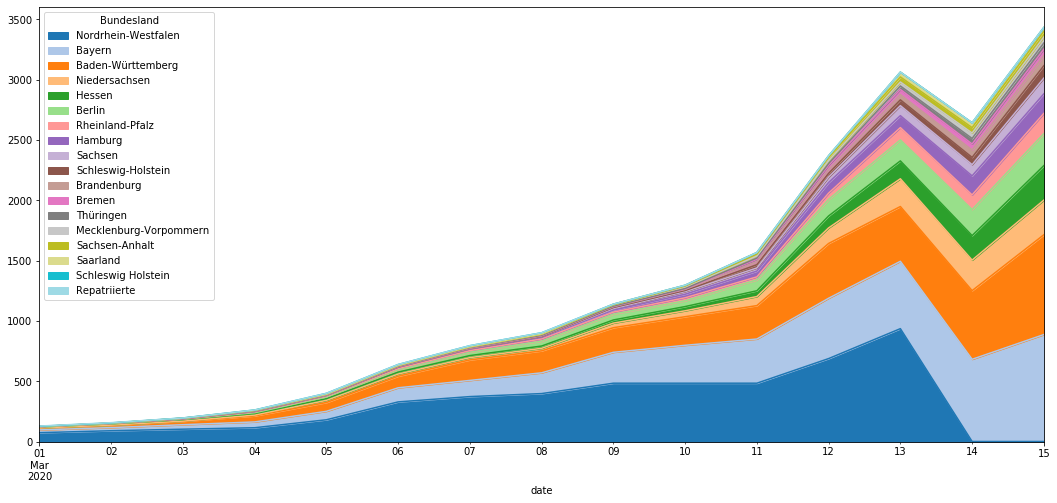

In [47]:
plot = confirmed.plot(figsize=(18,8), kind='area', cmap="tab20")

In [48]:
plot.get_figure().savefig("images/area_chart_infections_germany_by_state.png")

# Northern Germany

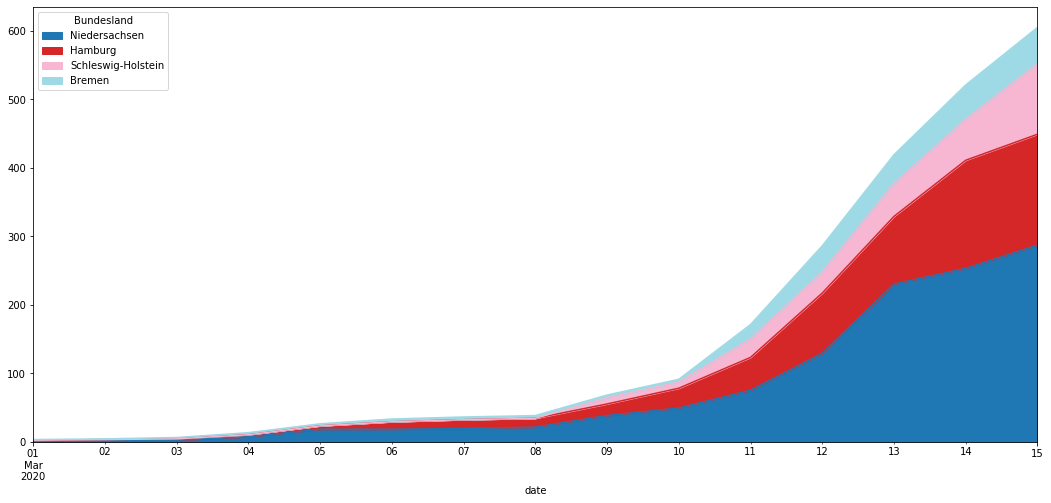

In [49]:
plot = confirmed[['Niedersachsen','Hamburg','Schleswig-Holstein','Bremen']].plot(figsize=(18,8), kind='area', cmap="tab20")

In [50]:
plot.get_figure().savefig("images/area_chart_infections_germany_northern_germany.png")

## Daily increases last 3 days

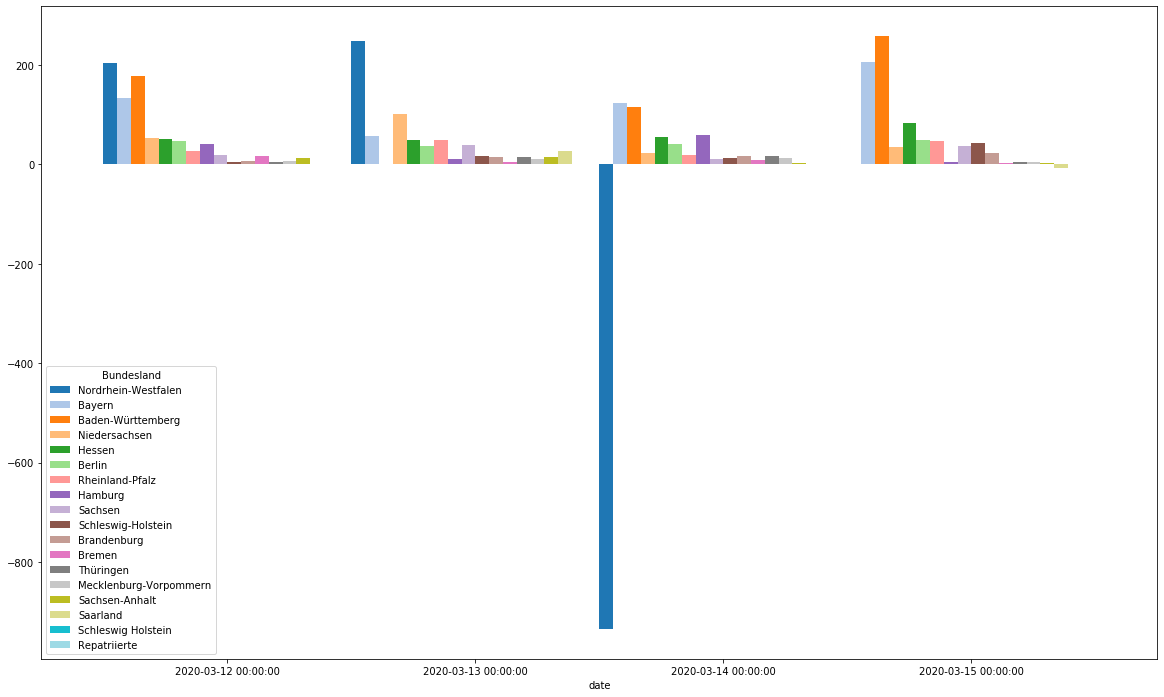

In [51]:
df_diff = confirmed.diff().tail(4)
plot = df_diff.plot(figsize=(20,12), cmap="tab20",  kind="bar", align='center', width=1.0, rot=0)

In [52]:
plot.get_figure().savefig("images/area_chart_dailydiffs_germany_by_state.png")